# Evaluación de modelos entrenados

In [1]:
import os
# Disable tf warnings
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

import matplotlib.pyplot as plt
import tensorflow as tf
import pandas as pd
from sklearn.metrics import mean_squared_error
import numpy as np
import pickle

2025-05-23 23:57:48.026800: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1748041068.047330 2898935 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1748041068.053971 2898935 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


## Carga de modelo

In [3]:
# Define the model architecture again (same as during training)
learning_rate = 0.005 #Should not matter for predictions

past_shape = [24, 7]  # (time_steps, num_features)
future_shape = [3, 4]  # (time_steps, num_features)
target_dim=3
# Encoder part (LSTM for past data)
past_in   = tf.keras.layers.Input(shape=past_shape,   name="past_data")
future_in = tf.keras.layers.Input(shape=future_shape, name="future_data")

# Past data 
past_lstm = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(42, return_sequences=False))(past_in)
past_lstm = tf.keras.layers.Dense(20)(past_lstm)

# Future exogenous features
future_dense = tf.keras.layers.Flatten()(future_in)
future_dense = tf.keras.layers.Dense(4)(future_dense)

# Combine the outputs of past and future
future_residue = tf.keras.layers.Flatten()(future_in)
merged = tf.keras.layers.concatenate([past_lstm, future_dense, future_residue])

# Final output layer
merged = tf.keras.layers.Dense(6* target_dim)(merged) 
out = tf.keras.layers.Dense(target_dim)(merged)

model = tf.keras.Model([past_in, future_in], out)

model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate), loss="mse")
model.summary()

path_checkpoint = "../trained_models/h_f3_1140.weights.h5"
model.load_weights(path_checkpoint)

# Optionally check the model summary to confirm weights have been loaded
model.summary()


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ past_data           │ (None, 24, 7)     │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ future_data         │ (None, 3, 4)      │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bidirectional_1     │ (None, 84)        │     16,800 │ past_data[0][0]   │
│ (Bidirectional)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten_2 (Flatten) │ (None, 12)        │          0 │ future_data[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_4 (Dense)     │ (None, 20)        │      1,700 │ bidirectional_1[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_5 (Dense)     │ (None, 4)         │         52 │ flatten_2[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten_3 (Flatten) │ (None, 12)        │          0 │ future_data[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_1       │ (None, 36)        │          0 │ dense_4[0][0],    │
│ (Concatenate)       │                   │            │ dense_5[0][0],    │
│                     │                   │            │ flatten_3[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_6 (Dense)     │ (None, 18)        │        666 │ concatenate_1[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_7 (Dense)     │ (None, 3)         │         57 │ dense_6[0][0]     │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 19,275 (75.29 KB)

 Trainable params: 19,275 (75.29 KB)

 Non-trainable params: 0 (0.00 B)

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ past_data           │ (None, 24, 7)     │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ future_data         │ (None, 3, 4)      │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bidirectional_1     │ (None, 84)        │     16,800 │ past_data[0][0]   │
│ (Bidirectional)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten_2 (Flatten) │ (None, 12)        │          0 │ future_data[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_4 (Dense)     │ (None, 20)        │      1,700 │ bidirectional_1[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_5 (Dense)     │ (None, 4)         │         52 │ flatten_2[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten_3 (Flatten) │ (None, 12)        │          0 │ future_data[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_1       │ (None, 36)        │          0 │ dense_4[0][0],    │
│ (Concatenate)       │                   │            │ dense_5[0][0],    │
│                     │                   │            │ flatten_3[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_6 (Dense)     │ (None, 18)        │        666 │ concatenate_1[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_7 (Dense)     │ (None, 3)         │         57 │ dense_6[0][0]     │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 19,275 (75.29 KB)

 Trainable params: 19,275 (75.29 KB)

 Non-trainable params: 0 (0.00 B)

## Datos entrenamiento

In [7]:
DATA_PATH = "../../3_data_windows/f3/paquetes_s6_cov_full_p24.pkl"

BATCH_SIZE = 64
DATASET = "relative_humidity"

with open(DATA_PATH, "rb") as f:
    data = pickle.load(f)
    
x_val = data["test"][DATASET]["past_variables"]
future_val = data["test"][DATASET]["future_variables"]
y_val = data["test"][DATASET]["y"]

dataset_val = tf.data.Dataset.from_tensor_slices(((x_val, future_val), y_val))
dataset_val = dataset_val.batch(BATCH_SIZE)


In [8]:
predictions_all = []
y_true_all = []

for batch in dataset_val:
    (x_past, x_future), y = batch
    predictions = model.predict((x_past, x_future))

    # Convert to numpy arrays and flatten
    y_np           = y.numpy().reshape(-1)
    predictions_np = predictions.reshape(-1)
    
    # Accumulate into lists
    y_true_all.extend(y_np.tolist())
    predictions_all.extend(predictions_np.tolist())

# Convert lists back to numpy arrays
y_true_arr      = np.array(y_true_all)
predictions_arr = np.array(predictions_all)

# Calculate RMSE
mse = mean_squared_error(y_true_arr, predictions_arr)
rmse = np.sqrt(mse)
print("MSE:", mse)
print("RMSE:", rmse)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
2/2 ━━━━━━━━

In [9]:
def denormalize(data, mean, std):
    """
    Denormalize the data using the mean and standard deviation.
    """
    return data * std + mean
  

In [10]:

MEAN = data["train"][DATASET]["mean"][-1]
STD = data["train"][DATASET]["std"][-1]

def plot_predictions(x_past, y, predictions):
# Denormalize
    history    = denormalize(x_past[:, -1], MEAN, STD)    # last feature over history window
    actual     = denormalize(y, MEAN, STD)
    forecast   = denormalize(predictions, MEAN, STD)

    H = len(history)
    F = len(actual)

    # Build continuous "actual" curve: history + actual future
    full_actual = np.concatenate([history, actual])

    # Build forecast curve that starts at the last history point
    # so its first value sits on history[-1]
    full_forecast = np.concatenate([[history[-1]], forecast])

    # Time axes
    t_full = np.arange(H + F)                            # for full_actual
    t_forc = np.arange(H - 1, H - 1 + len(full_forecast))  # for full_forecast

    # Plot
    plt.figure(figsize=(14, 6))
    plt.plot(t_full,      full_actual,    label='Actual (history + future)', linewidth=2)
    plt.plot(t_forc,      full_forecast,  label='Forecast',               linestyle='--', linewidth=2)
    plt.axvline(H - 1,    linestyle=':',  linewidth=1.5,             label='Forecast start')
    plt.grid(alpha=0.3)
    plt.title('Time Series: History → Actual vs. Forecast')
    plt.xlabel('Time Step')
    plt.ylabel('Value')
    plt.legend()
    plt.tight_layout()
    plt.show()

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
predictions shape: 64


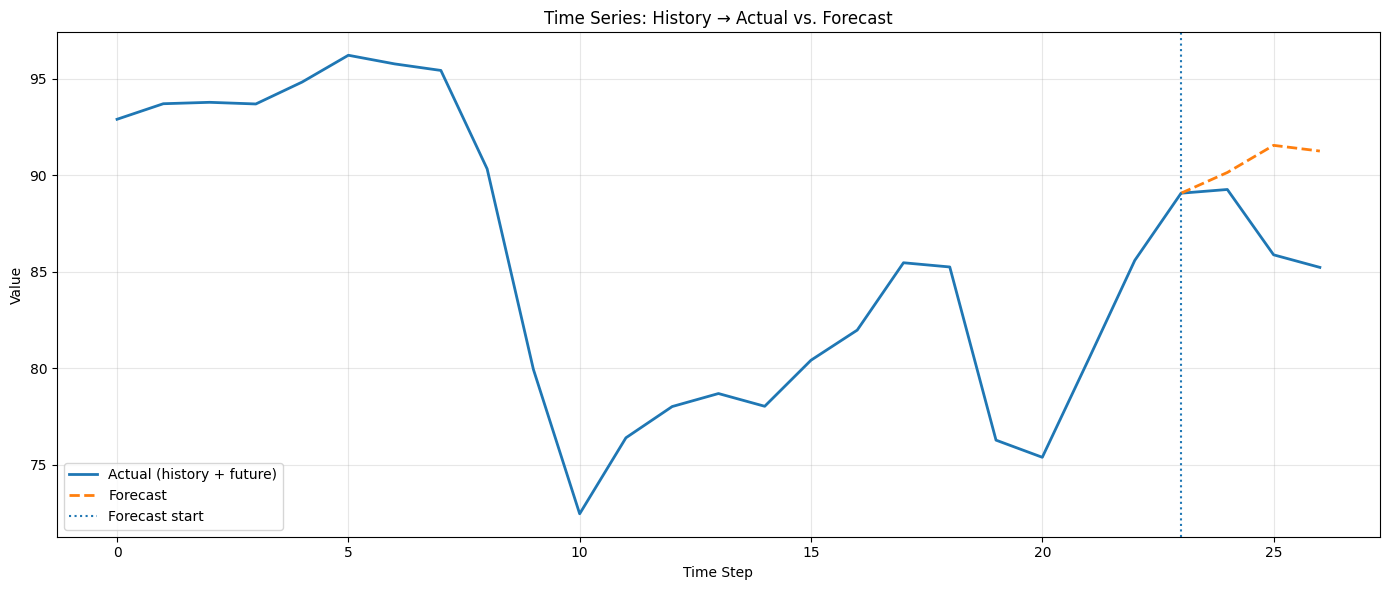

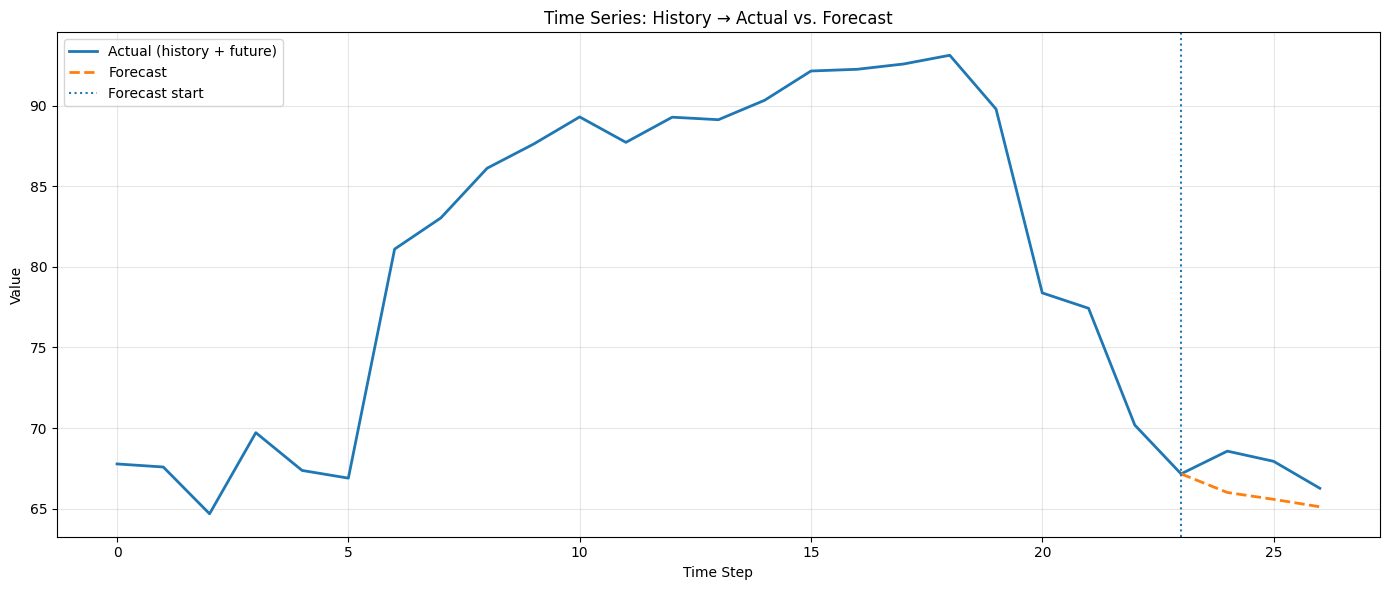

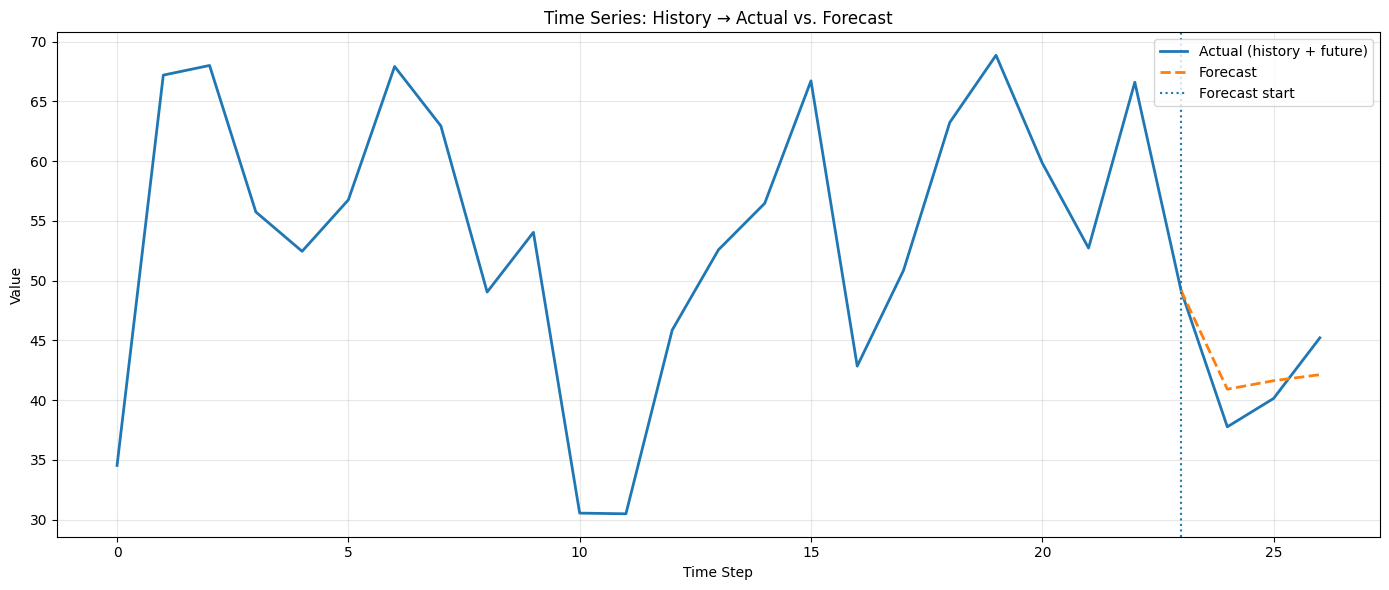

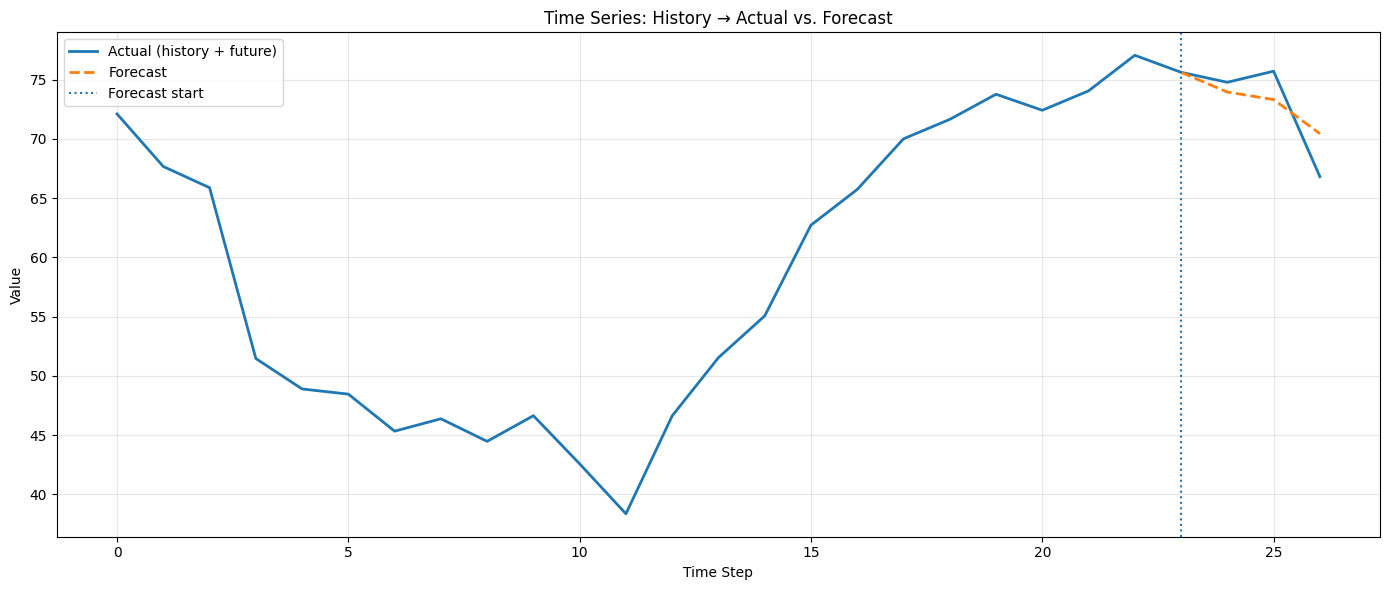

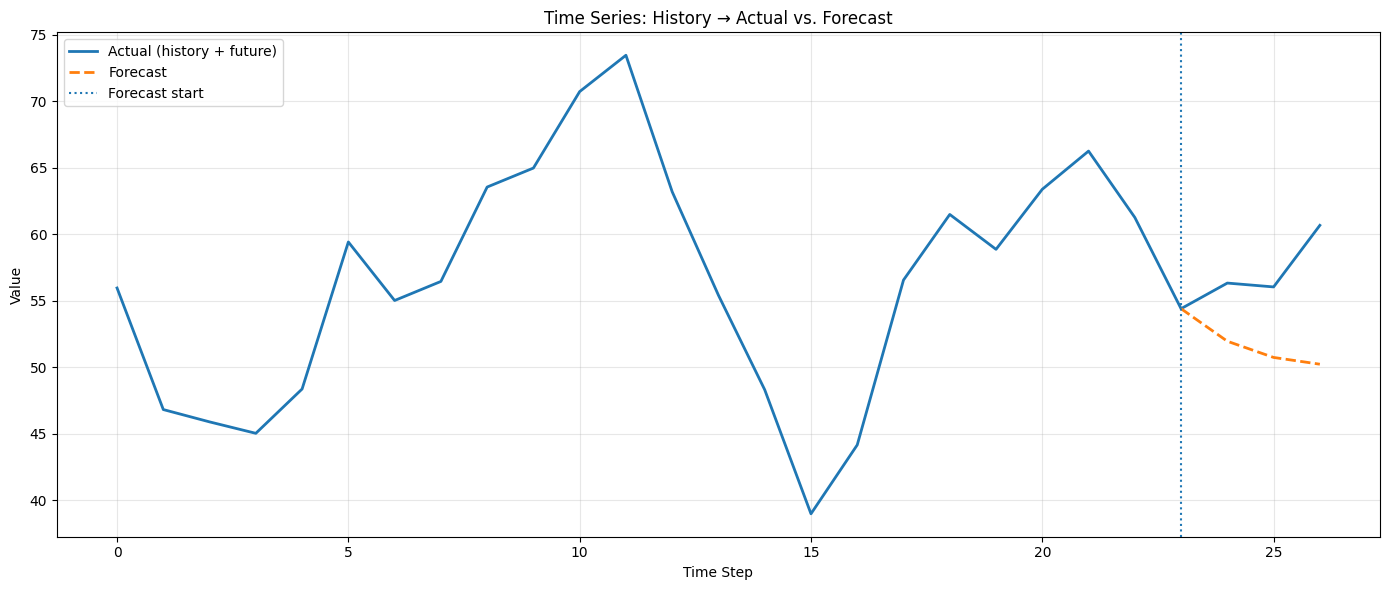

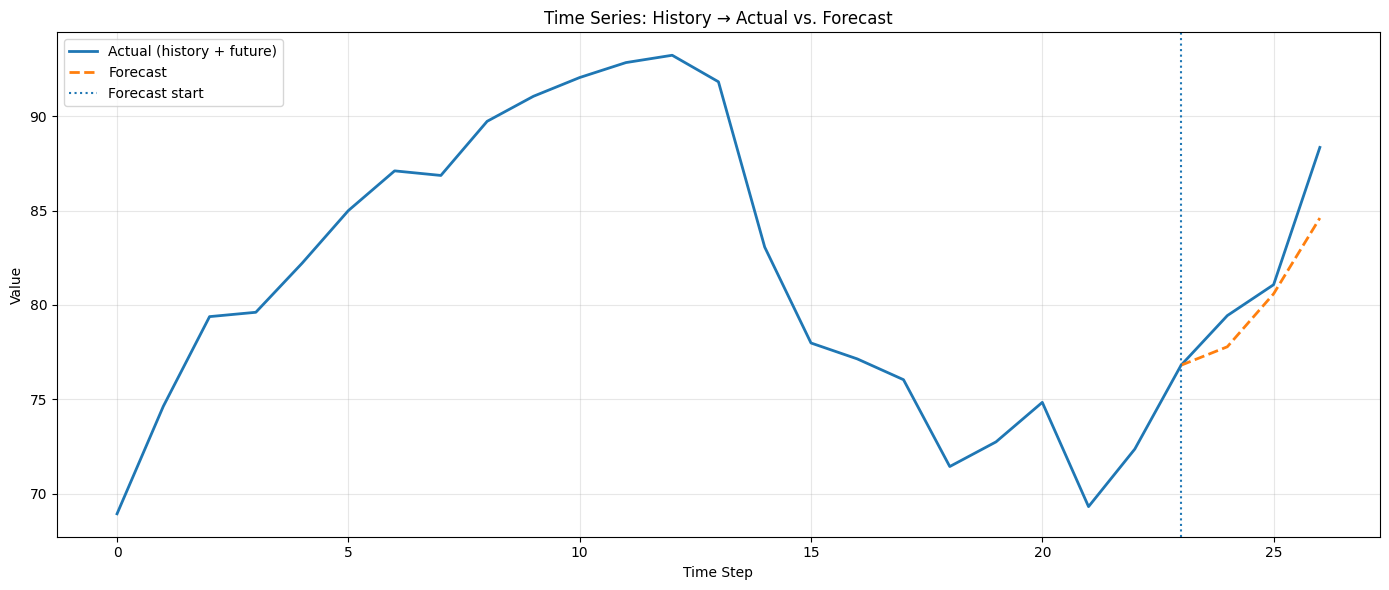

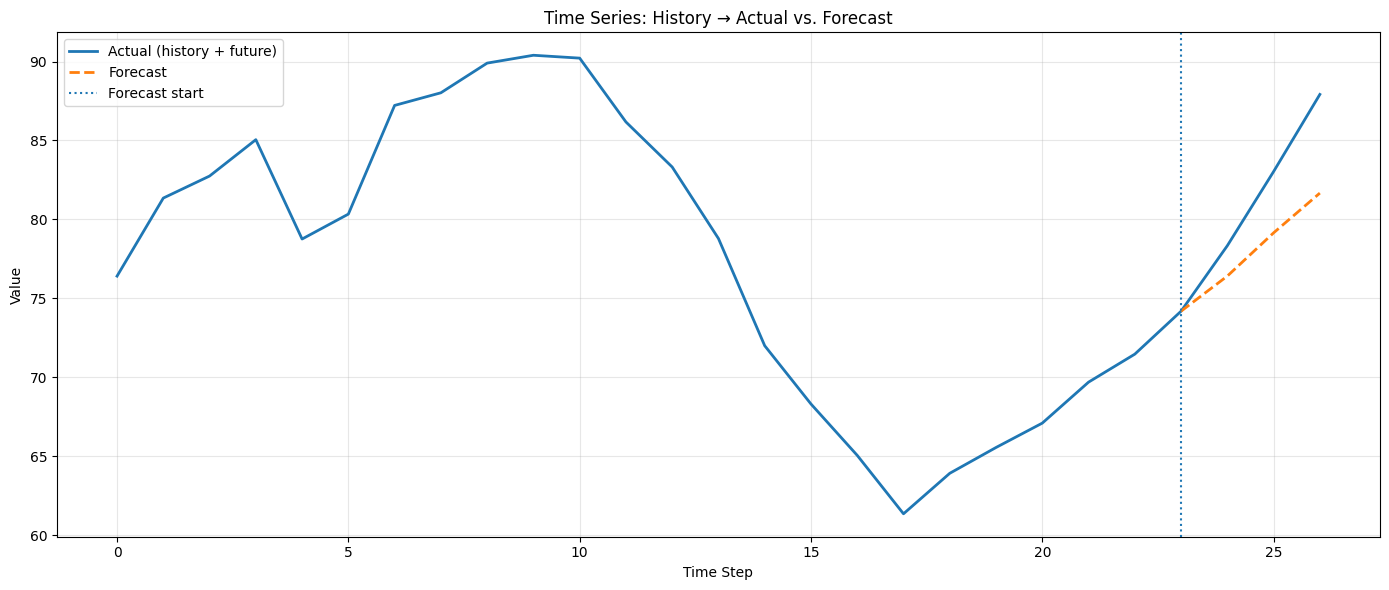

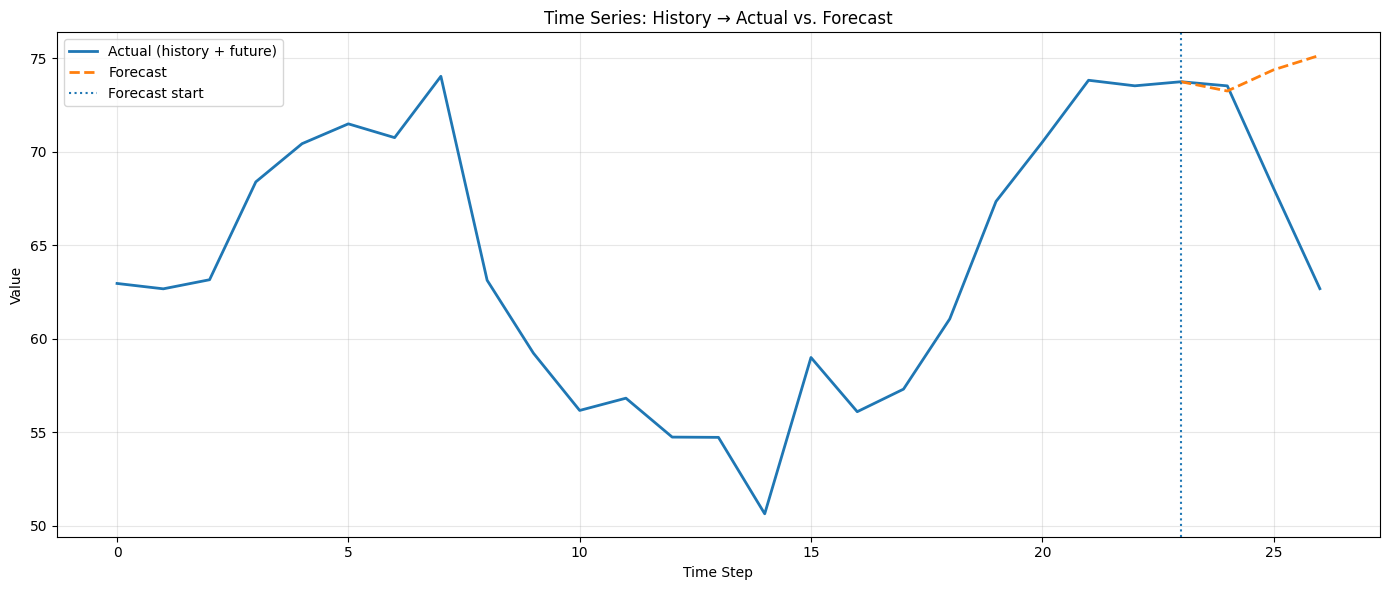

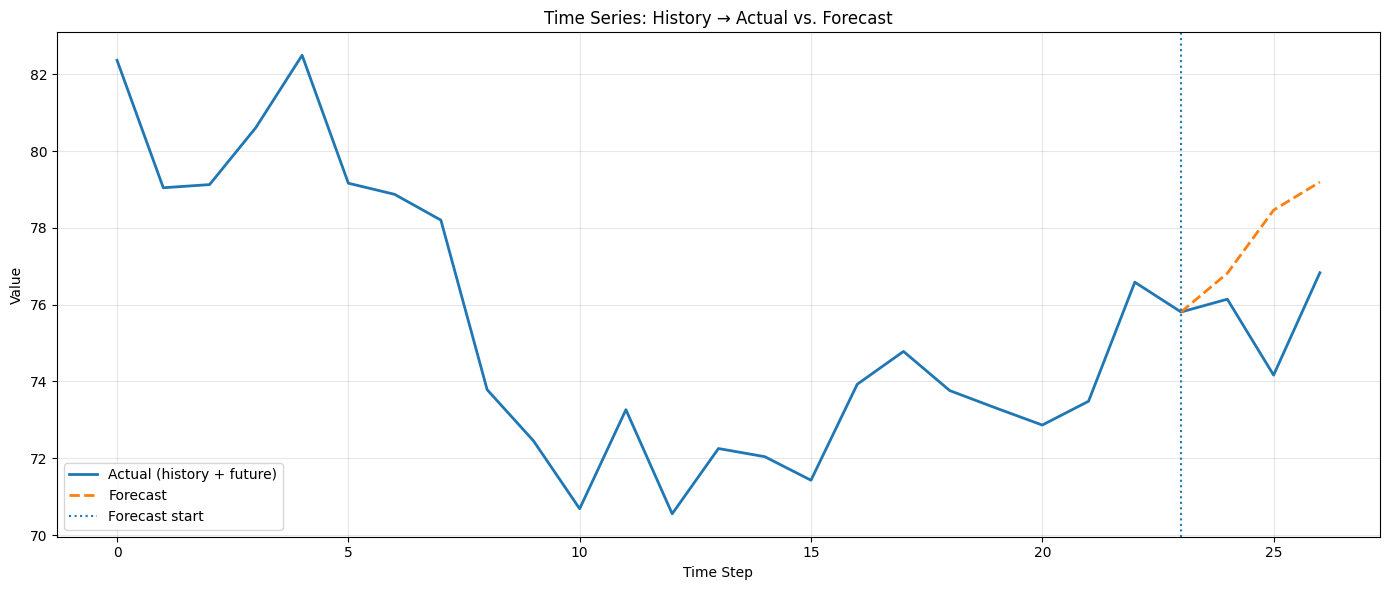

In [11]:

for batch in dataset_val.take(1):
    (x_past, x_future), y = batch
    predictions = model.predict((x_past, x_future))

    print("predictions shape:", predictions.shape[0])
    for i in range(0, 9):
        plot_predictions(x_past[i], y[i], predictions[i])
        plt.show()

## Validación

In [34]:
DATA_PATH = "../../3_data_windows/f3_val/paquetes_s6_cov_openmeteo_la_laguna_p24.pkl"

BATCH_SIZE = 64

with open(DATA_PATH, "rb") as f:
    data = pickle.load(f)
    
x_val = data[DATASET]["past_variables"]
future_val = data[DATASET]["future_variables"]
y_val = data[DATASET]["y"]

dataset_val = tf.data.Dataset.from_tensor_slices(((x_val, future_val), y_val))
dataset_val = dataset_val.batch(BATCH_SIZE)

In [35]:
predictions_all = []
y_true_all = []

for batch in dataset_val:
    (x_past, x_future), y = batch
    predictions = model.predict((x_past, x_future))

    # Convert to numpy arrays and flatten
    y_np           = y.numpy().reshape(-1)
    predictions_np = predictions.reshape(-1)
    
    # Accumulate into lists
    y_true_all.extend(y_np.tolist())
    predictions_all.extend(predictions_np.tolist())

# Convert lists back to numpy arrays
y_true_arr      = np.array(y_true_all)
predictions_arr = np.array(predictions_all)

# Calculate RMSE
mse = mean_squared_error(y_true_arr, predictions_arr)
rmse = np.sqrt(mse)
print("MSE:", mse)
print("RMSE:", rmse)
print("Denormalized RMSE:", rmse * STD)

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
MSE: 0.058005569495104985
RMSE: 0.2408434543331103
Denormalized RMSE: 4.102223200442925
